<a href="https://colab.research.google.com/github/basakesin/InsectAI-WG3-STSM/blob/main/Google_Colab_Notebooks/train_model_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train your model with PyTorch

The **`train_model_with_pytorch.ipynb` notebook** provides a user-friendly workflow for training image classification models on custom insect datasets.  
Its goal is to support researchers and students (even those with limited coding experience) in preparing data, training deep learning models, and exporting them in formats ready for deployment.  

To demonstrate the workflow, we tested the code in **Google Colab** using the [Butterfly & Moths Image Classification (100 species) dataset](https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species).  
You are also free to test the notebook with your own dataset.  


## With this notebook, you can:
- **Prepare datasets** by splitting images into training, validation, and test sets.  
- **Select and train a model** from popular backbones (*MobileNetV2*, *EfficientNetB0*, *ResNet50*, *InceptionV3*).  
- **Monitor performance** with accuracy/loss plots and confusion matrices.  
- **Generate a `class_names.txt` file** mapping folder names (species) to model outputs.  
- **Export trained models** in multiple formats:  
  - PyTorch checkpoint (`.pt/.pth`)  
  - **TorchScript**  
  - **ONNX** (for interoperability).  
- **Download models** easily with built-in buttons.  


## Run the Notebook

Click **Runtime $\rightarrow$ Run All** to execute all cells sequentially, or run them individually using the **Run** button (triangle icon).

- When a cell finishes successfully, a green check mark ✅ and the execution time will appear.

- While a cell is still running, you will see a spinning circle icon 🔄 please wait until it completes before moving on.

- The notebook contains 6 main code cells, illustrated in the block diagram below. Follow the workflow by scrolling down the page and make sure that all cells show a green check mark ✅.

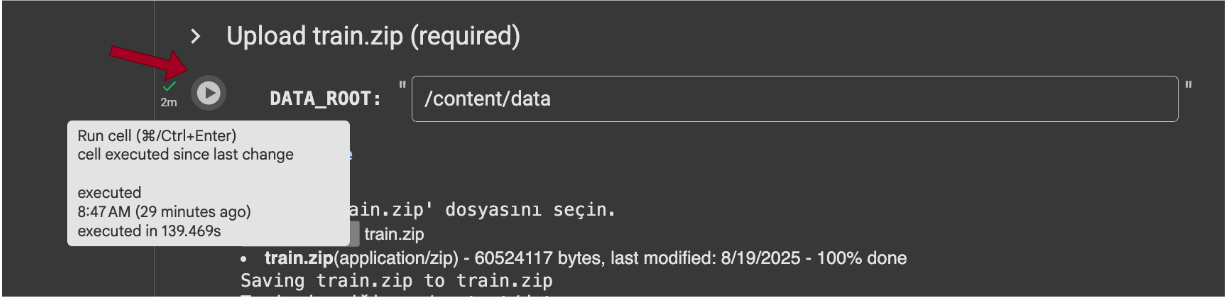


⚠️ **Important:** Make sure you run the Colab notebook under the **same Google account** that owns the Drive you want to mount. Otherwise, the authorization will fail.  

The block diagram below summarizes the workflow step by step, highlighting which steps require user input, which apply defaults, and which only need to be executed without modification.

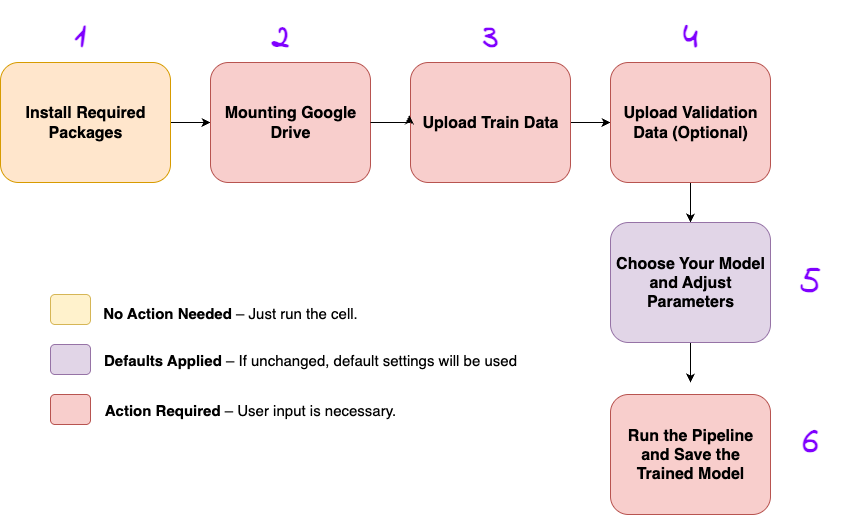


In [ ]:
# @title 1-Install Required Packages
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    # for optional auto-split
    !pip -q install split-folders
    !pip install onnx


import os, shutil, zipfile, itertools, io, json, math, time, csv
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
import onnx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import ipywidgets as widgets
from IPython.display import display,Markdown
from sklearn.metrics import confusion_matrix, classification_report
import threading
try:
    from google.colab import files, drive
except Exception:
    files, drive = None, None

# Reproducibility
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Utils
def unzip_to(out_dir: Path, zip_path: str):
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(out_dir)

def maybe_flatten_one_folder(root: Path):
    entries = [p for p in root.iterdir() if p.is_dir() or p.is_file()]
    if len(entries) == 1 and entries[0].is_dir():
        inner = entries[0]
        for p in inner.iterdir():
            shutil.move(str(p), root / p.name)
        shutil.rmtree(inner)

def save_class_names_list(classes: List[str], out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_path, "w", encoding="utf-8") as f:
        for cls in classes:
            f.write(cls + "\n")
    print("Saved class names to:", out_path)

def plot_curves(history: Dict[str, List[float]], out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)

    # Loss curve
    plt.figure()
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")
    plt.savefig(out_dir / "loss_curve.png", bbox_inches="tight")
    plt.show()   #also display on screen
    plt.close()

    # Accuracy curve
    plt.figure()
    plt.plot(history["train_acc"], label="train_acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.savefig(out_dir / "accuracy_curve.png", bbox_inches="tight")
    plt.show()   # also display on screen
    plt.close()

    print("Saved curves to", out_dir)


def plot_confusion(cm: np.ndarray, classes: List[str], out_path: Path):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha="right")
    plt.yticks(ticks, classes)
    thresh = cm.max()/2.0 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i,j]:d}", ha="center",
                     color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight"); plt.close()
    print("Saved confusion matrix to", out_path)

def create_model(backbone: str, num_classes: int) -> nn.Module:
    b = backbone.lower()
    if b == "resnet50":
        net = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_feats = net.fc.in_features
        net.fc = nn.Linear(in_feats, num_classes)
    elif b == "mobilenetv2" or b == "mobilenet_v2":
        net = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        in_feats = net.classifier[-1].in_features
        net.classifier[-1] = nn.Linear(in_feats, num_classes)
    elif b == "efficientnetb0" or b == "efficientnet_b0":
        net = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        in_feats = net.classifier[-1].in_features
        net.classifier[-1] = nn.Linear(in_feats, num_classes)
    elif b == "inceptionv3" or b == "inception_v3":
        net = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, aux_logits=False)
        in_feats = net.fc.in_features
        net.fc = nn.Linear(in_feats, num_classes)
    else:
        raise ValueError(f"Unsupported backbone: {backbone}")
    return net

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / max(total,1), correct / max(total,1)

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    all_t, all_p = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        tot_loss += loss.item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        all_t.extend(y.cpu().tolist())
        all_p.extend(pred.cpu().tolist())
    return tot_loss / max(total,1), correct / max(total,1), np.array(all_t), np.array(all_p)

# Custom CSV dataset (filepath,label)
from PIL import Image
class CSVDataset(Dataset):
    def __init__(self, rows: List[Tuple[str,int]], transform=None):
        self.rows = rows
        self.transform = transform
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, idx):
        p, y = self.rows[idx]
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, y


Prepare Your Dataset  
   Organize your insect images so each species has its own folder:

```
train/
├── butterfly/
│   ├── img1.jpg
│   ├── img2.jpg
│   └── ...
└── beetle/
    ├── img1.jpg
    ├── img2.jpg
    └── ...
```

Create a train.zip file to upload.


<h3>Mount Google Drive and Upload Your Files  </h3>

Mount Google Drive and upload the notebook to your dataset (`train.zip`) folder.  

⚠️ **Important:** Make sure you run the Colab notebook under the **same Google account** that owns the Drive you want to mount. Otherwise, the authorization will fail.  

Follow these steps:  
1. Click on the URL provided in the output.  
2. Select the **Google account you want to use**.  
3. Allow Google Colab to access your Google Drive.  
4. Choose your zip file (`train.zip`) and upload it.  


In [ ]:
# @title 2-Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# @title 3-Upload train data (train.zip (required))
print("Please upload your train.zip file")
uploaded_train = files.upload()

train_zip = list(uploaded_train.keys())[0]
train_dir = "/content/data/"
os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile(train_zip, 'r') as z:
    z.extractall(train_dir)
print(f"Extracted {train_zip} to {train_dir}")





In [ ]:
# @title 4-Upload Validation Data (val.zip (optional))
print("\n (Optional) If you have a validation.zip, upload it now. Otherwise, just skip by pressing cancel.")
uploaded_val = files.upload()

if uploaded_val:
    val_zip = list(uploaded_val.keys())[0]
    val_dir = "/content/data/"
    os.makedirs(val_dir, exist_ok=True)

    with zipfile.ZipFile(val_zip, 'r') as z:
        z.extractall(val_dir)
    print(f"Extracted {val_zip} to {val_dir}")
else:
    print("No validation.zip uploaded. Proceeding with train data only.")

<h1>Choose Your Model and Adjust Parameters</h1>

These settings appear **below the cell as form fields**. You can change them without editing the code directly.

<h2>General Settings</h2>

- **DATA_DIR** – The folder where your dataset is stored. In Colab, you usually upload your images into this path.  
- **USE_LABELS_CSV** – If your dataset comes with a separate CSV file containing labels, set this to `True`. Otherwise, leave it as `False`.  
- **LABELS_CSV_PATH** – The file path to your labels CSV (only needed if the option above is `True`).  
- **BACKBONE** – The model architecture to use for training. Options: *EfficientNetB0*, *MobileNetV2*, *ResNet50*, *InceptionV3*. (Think of this as choosing a “brain” for your AI model.)  

<h2> Training Parameters</h2>

- **IMG_SIZE** – The size to which all images will be resized (e.g., `224 × 224` pixels).  
- **BATCH_SIZE** – Number of images processed together in one training step.  
- **EPOCHS** – How many times the model will go through the full dataset during training.  
- **VAL_SPLIT** – The fraction of the dataset used for validation (e.g., `0.2` = 20%).  
- **AUTO_SPLIT_IF_NO_VAL** – If `True`, Colab will automatically create a validation split if none is provided.  
- **AUGMENTATION** – If `True`, applies small changes (rotation, flipping, etc.) to images to improve robustness.  
- **LEARNING_RATE** – How fast the model learns. A smaller number = slower but more stable learning.  
- **OUTPUT_DIR** – The folder where all results (trained model files, logs, etc.) will be saved.  


In [ ]:
# @title 5-Choose your model and adjust parameters
DATA_DIR = '/content/data' #@param {type:"string"}
USE_LABELS_CSV = False #@param {type:"boolean"}
LABELS_CSV_PATH = '/content/data/my_dataset/labels.csv' #@param {type:"string"}

BACKBONE = 'MobileNetV2' #@param ["EfficientNetB0", "MobileNetV2", "ResNet50", "InceptionV3"]

# Training parameters
IMG_SIZE = 224 #@param {type:"integer"}
BATCH_SIZE = 32 #@param {type:"integer"}
EPOCHS = 3 #@param {type:"integer"}
VAL_SPLIT = 0.2 #@param {type:"number"}
AUTO_SPLIT_IF_NO_VAL = True #@param {type:"boolean"}
AUGMENTATION = False #@param {type:"boolean"}
LEARNING_RATE = 0.0005 #@param {type:"number"}

OUTPUT_DIR = '/content/output' #@param {type:"string"}
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Backbone name normalization for torchvision
_backbone_map = {
    "EfficientNetB0":"efficientnet_b0",
    "MobileNetV2":"mobilenet_v2",
    "ResNet50":"resnet50",
    "InceptionV3":"inception_v3"
}
BACKBONE_TORCH = _backbone_map.get(BACKBONE, BACKBONE)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


In [ ]:
# @title 6-Run the Pipeline and Save the Trained Model
def get_params_snapshot():
    keys = [
        "DATA_DIR", "USE_LABELS_CSV", "LABELS_CSV_PATH",
        "BACKBONE", "BACKBONE_TORCH",
        "IMG_SIZE", "BATCH_SIZE", "EPOCHS",
        "VAL_SPLIT", "AUTO_SPLIT_IF_NO_VAL", "AUGMENTATION",
        "LEARNING_RATE", "OUTPUT_DIR",
        "device"
    ]
    snap = {}
    for k in keys:
        if k in globals():
            v = globals()[k]
            try:
                json.dumps(v)  # serializable?
                snap[k] = v
            except TypeError:
                snap[k] = str(v)
    return snap
def run_training():
    global OUTPUT_DIR
    snap = get_params_snapshot()
    print(snap)


    train_dir = os.path.join(DATA_DIR, 'train')
    val_dir   = os.path.join(DATA_DIR, 'val')

    # Transforms
    transform_train = [transforms.Resize((IMG_SIZE, IMG_SIZE))]
    if AUGMENTATION:
        transform_train += [transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(10)]
    transform_train += [transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485,0.456,0.406],
                                             std=[0.229,0.224,0.225])]
    transform_train = transforms.Compose(transform_train)

    transform_eval = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])])

    if not USE_LABELS_CSV:
        # Folder-structured dataset
        if os.path.isdir(train_dir) and (not os.path.isdir(val_dir)) and AUTO_SPLIT_IF_NO_VAL:
            # auto split train_dir into train/val
            import splitfolders
            tmp_out = '/content/data_split'
            if os.path.exists(tmp_out): shutil.rmtree(tmp_out)
            splitfolders.ratio(train_dir, output=tmp_out, seed=42,
                               ratio=(1-VAL_SPLIT, VAL_SPLIT))
            DATA_DIR2 = tmp_out
            train_dir = os.path.join(DATA_DIR2, 'train')
            val_dir   = os.path.join(DATA_DIR2, 'val')

        print('train_dir:', train_dir)
        print('val_dir  :', val_dir)

        train_ds = datasets.ImageFolder(train_dir, transform=transform_train)
        val_ds   = datasets.ImageFolder(val_dir,   transform=transform_eval)
        class_names = train_ds.classes
    else:
        # CSV dataset branch
        import pandas as pd
        df = pd.read_csv(LABELS_CSV_PATH)
        cols = {c.lower():c for c in df.columns}
        path_col  = cols.get('filepath') or cols.get('file') or cols.get('image') or list(df.columns)[0]
        label_col = cols.get('label') or cols.get('class') or list(df.columns)[1]

        paths = df[path_col].astype(str).tolist()
        raw_labels = df[label_col].tolist()

        if not np.issubdtype(np.array(raw_labels).dtype, np.number):
            class_names = sorted(list({str(l) for l in raw_labels}))
            name_to_idx = {n:i for i,n in enumerate(class_names)}
            labels = [name_to_idx[str(l)] for l in raw_labels]
        else:
            labels = [int(l) for l in raw_labels]
            class_names = [str(i) for i in sorted(set(labels))]

        n_total = len(paths)
        n_val   = int(n_total * VAL_SPLIT)
        idx = np.arange(n_total)
        np.random.seed(42); np.random.shuffle(idx)
        val_idx   = idx[:n_val]
        train_idx = idx[n_val:]

        rows_train = [(paths[i], labels[i]) for i in train_idx]
        rows_val   = [(paths[i], labels[i]) for i in val_idx]

        train_ds = CSVDataset(rows_train, transform=transform_train)
        val_ds   = CSVDataset(rows_val,   transform=transform_eval)

    # Save class names

    save_class_names_list(class_names, Path(OUTPUT_DIR) / "class_names.txt")
    NUM_CLASSES = len(class_names)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=2, pin_memory=True)

    model = create_model(BACKBONE_TORCH, num_classes=NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    BACKBONE = globals().get("BACKBONE", "model").lower()

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    best_val_acc = 0.0
    best_ckpt_path = Path(OUTPUT_DIR) / f"{BACKBONE}_best.pth"

    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch:02d}/{EPOCHS} - "
              f"loss: {tr_loss:.4f} acc: {tr_acc:.4f} - "
              f"val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_ckpt_path)
            print("Saved best checkpoint:", best_ckpt_path)

    print("Training finished.")

    cm = confusion_matrix(y_true, y_pred)
    plot_curves(history, Path(OUTPUT_DIR))
    plot_confusion(cm, class_names, Path(OUTPUT_DIR) / "confusion_matrix.png")
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    with open(Path(OUTPUT_DIR) / "classification_report.txt", "w", encoding="utf-8") as f:
        f.write(report)
    print(report)


    final_ckpt_path = Path(OUTPUT_DIR) / f"{BACKBONE}_final.pth"
    torch.save(model.state_dict(), final_ckpt_path)
    print("Saved final checkpoint to:", final_ckpt_path)
    print("Class names saved at:", Path(OUTPUT_DIR) / "class_names.txt")

    # Also export TorchScript and ONNX
    example = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)
    ts_path = Path(OUTPUT_DIR) / "artifact" / "model.torchscript.pt"
    onnx_path = Path(OUTPUT_DIR) / "artifact" / f"{BACKBONE}.onnx"
    ts_path.parent.mkdir(parents=True, exist_ok=True)

    traced = torch.jit.trace(model.eval(), example)
    traced.save(str(ts_path))
    torch.onnx.export(model.eval(), example, str(onnx_path),
                      input_names=['input'], output_names=['logits'],
                      opset_version=12, dynamic_axes={'input':{0:'batch'}, 'logits':{0:'batch'}})
    print("Saved TorchScript:", ts_path)
    print("Saved ONNX:", onnx_path)


    # --- Safe download helper (define once) ---
    if '_safe_download' not in globals():
        def _safe_download(path):
            if os.path.exists(path):
                files.download(path)
                print(f"Downloading: {os.path.basename(path)}")
            else:
                print(f"Not found: {path}")

    # --- Helper: first existing path ---
    def _first_existing(paths):
        for p in paths:
            if p and os.path.exists(p):
                return p
        return None

    # --- Paths (defensive defaults) ---
    OUTPUT_DIR = str(os.environ.get("OUTPUT_DIR", "/content/output"))
    BACKBONE = str(globals().get("BACKBONE", "model")).lower()

    def _maybe(v, fallback):
        return str(v) if v is not None else fallback

    final_ckpt_path = _maybe(globals().get("final_ckpt_path", None),
                             os.path.join(OUTPUT_DIR, f"{BACKBONE}_final.pth"))
    best_ckpt_path  = _maybe(globals().get("best_ckpt_path",  None),
                             os.path.join(OUTPUT_DIR, f"{BACKBONE}_best.pth"))
    ts_path         = _maybe(globals().get("ts_path",         None),
                             os.path.join(OUTPUT_DIR, f"{BACKBONE}_final_torchscript.pt"))
    onnx_path       = _maybe(globals().get("onnx_path",       None),
                             os.path.join(OUTPUT_DIR, f"{BACKBONE}_final.onnx"))

    # TorchScript fallbacks
    ts_candidates = [
        ts_path,
        os.path.join(OUTPUT_DIR, f"{BACKBONE}_scripted.pt"),
        os.path.join(OUTPUT_DIR, f"{BACKBONE}_traced.pt"),
        os.path.join(OUTPUT_DIR, f"{BACKBONE}.pt"),
    ]

    # Common side files
    classes_path = os.path.join(OUTPUT_DIR, "class_names.txt")
    loss_png     = os.path.join(OUTPUT_DIR, f"{BACKBONE}_loss_curve.png")
    acc_png      = os.path.join(OUTPUT_DIR, f"{BACKBONE}_accuracy_curve.png")
    cm_png       = os.path.join(OUTPUT_DIR, f"{BACKBONE}_confusion_matrix.png")
    report_txt   = os.path.join(OUTPUT_DIR, f"{BACKBONE}_classification_report.txt")

    # --- Button factory ---
    def make_button(label, path_or_callable):
        btn = widgets.Button(
            description=label,
            button_style='primary',
            layout=widgets.Layout(width="320px", height="44px")
        )
        out = widgets.Output()

        def _resolve_path():
            return path_or_callable() if callable(path_or_callable) else path_or_callable

        # Set initial enabled/disabled
        p_init = _resolve_path()
        btn.disabled = not (p_init and os.path.exists(p_init))

        def _on_click(_):
            with out:
                p = _resolve_path()
                if p and os.path.exists(p):
                    _safe_download(p)
                else:
                    print(f"Not found: {p}")

        btn.on_click(_on_click)
        return btn, out

    # --- Build buttons ---
    btn_final, out_final = make_button(f"Download {BACKBONE}_final.pth", final_ckpt_path)
    btn_best,  out_best  = make_button(f"Download {BACKBONE}_best.pth",  best_ckpt_path)
    btn_ts,    out_ts    = make_button(f"Download TorchScript ({BACKBONE}.pt)",
                                       lambda: _first_existing(ts_candidates))
    btn_onnx,  out_onnx  = make_button(f"Download {BACKBONE}.onnx", onnx_path)
    btn_cls,   out_cls   = make_button("Download class_names.txt", classes_path)

    # Optional: add plots/report buttons if you generate them
    btn_loss,  out_loss  = make_button(f"Download {BACKBONE}_loss_curve.png", loss_png)
    btn_acc,   out_acc   = make_button(f"Download {BACKBONE}_accuracy_curve.png", acc_png)
    btn_cm,    out_cm    = make_button(f"Download {BACKBONE}_confusion_matrix.png", cm_png)
    btn_rep,   out_rep   = make_button(f"Download {BACKBONE}_classification_report.txt", report_txt)

    # --- Layout ---
    header = widgets.HTML(
        f"<h2>Download Your {BACKBONE.upper()} Model Files</h2>"
        "<p>Click any button to download the corresponding file. "
        "If a button is disabled, run the related export/evaluation step first.</p>"
    )

    row1 = widgets.HBox([btn_final, btn_best, btn_ts])
    row2 = widgets.HBox([btn_onnx, btn_cls])
    row3 = widgets.HBox([btn_loss, btn_acc, btn_cm, btn_rep])
    outs = widgets.VBox([out_final, out_best, out_ts, out_onnx, out_cls, out_loss, out_acc, out_cm, out_rep])

    box = widgets.VBox([header, row1, row2, row3, outs])
    display(box)



STATE = globals().setdefault("_ONEBTN_STATE", {"running": False, "confirmed": False})

run_btn = widgets.Button(
    description="Run Pipeline",
    button_style="success",
    layout=widgets.Layout(width="220px", height="42px")
)

def _safe_call(*names):
    """Verilen isimlerden mevcut ve çağrılabilir olan ilk fonksiyonu çağır."""
    for name in names:
        fn = globals().get(name)
        if callable(fn):
            return fn()


def _confirm_params_once():
    """Parametre onayı: varsa PARAMS_LOCKED=True yapar."""
    if not STATE["confirmed"]:
        globals()["PARAMS_LOCKED"] = True
        STATE["confirmed"] = True
        print("Parameters confirmed.")

def on_run(_):
    if STATE["running"]:
        print("⏳ Already running…")
        return

    STATE["running"] = True
    run_btn.description = "⏳ Running..."
    run_btn.disabled = True

    _confirm_params_once()

    try:
        # 0) Parametre özetini al
        snap_local = get_params_snapshot()

        # Kısa özet
        print(
            f"BACKBONE={snap_local.get('BACKBONE')}, IMG_SIZE={snap_local.get('IMG_SIZE')}, "
            f"BATCH_SIZE={snap_local.get('BATCH_SIZE')}, EPOCHS={snap_local.get('EPOCHS')}, "
            f"LR={snap_local.get('LEARNING_RATE')}, AUGMENTATION={snap_local.get('AUGMENTATION')}, "
            f"VAL_SPLIT={snap_local.get('VAL_SPLIT')}"
        )
        print(f"DATA_DIR={snap_local.get('DATA_DIR')}, USE_LABELS_CSV={snap_local.get('USE_LABELS_CSV')}")

        # 1) Training
        _safe_call("run_training", "train", "start_training")

    finally:
        run_btn.description = "✅ Done"
        STATE["running"] = False
        run_btn.disabled = False


run_btn.on_click(on_run)

display(Markdown("### Pipeline"))
display(run_btn)

